# JIT compilation and parallelism with Numba

[Numba](https://numba.pydata.org/) is an accelerator library for Python, which just-in time compiles Python code into fast machine code. If used right, its performance can be close to optimized C code. Moreover, it supports offloading of kernels to GPU devices and shared memory parallelism.

The following example from the Numba homepage provides a very first idea of what Numba does.

In [2]:
from numba import jit
from numpy import arange

# jit decorator tells Numba to compile this function.
# The argument types will be inferred by Numba when function is called.
@jit
def sum2d(arr):
    M, N = arr.shape
    result = 0.0
    for i in range(M):
        for j in range(N):
            result += arr[i,j]
    return result

a = arange(9).reshape(3,3)
print(sum2d(a))

36.0


On its first call the `sum2d` function is just-in-time compiled into fast executable code and then executed.

In the following we want to use Numba to compute the Mandelbrot fractal and measure its performance. First, we define a simple convenient timer in Python.

In [3]:
import time

class Timer:    
    def __enter__(self):
        self.start = time.time()
        return self

    def __exit__(self, *args):
        self.end = time.time()
        self.interval = self.end - self.start

The following is a pure Python implementation of the Mandelbrot set. It is derived from the Numba documentation.

Time to create fractal: 29.754865884780884


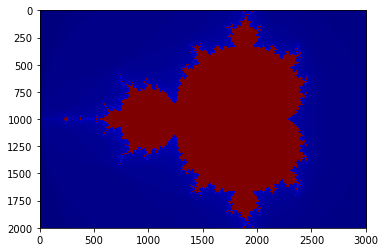

In [5]:
%matplotlib inline

#from __future__ import print_function, division, absolute_import
import numpy as np
from pylab import imshow, jet, show, ion

def mandel(x, y, max_iters):
    """
    Given the real and imaginary parts of a complex number,
    determine if it is a candidate for membership in the Mandelbrot
    set given a fixed number of iterations.
    """
    i = 0
    c = complex(x,y)
    z = 0.0j
    for i in range(max_iters):
        z = z*z + c
        if (z.real*z.real + z.imag*z.imag) >= 4:
            return i

    return 255

def create_fractal(min_x, max_x, min_y, max_y, image, iters):
    height = image.shape[0]
    width = image.shape[1]

    pixel_size_x = (max_x - min_x) / width
    pixel_size_y = (max_y - min_y) / height
    for x in range(width):
        real = min_x + x * pixel_size_x
        for y in range(height):
            imag = min_y + y * pixel_size_y
            color = mandel(real, imag, iters)
            image[y, x] = color

    return image

image = np.zeros((2000, 3000), dtype=np.uint8)

with Timer() as t:
    mandelbrot = create_fractal(-2.0, 1.0, -1.0, 1.0, image, 20)
print("Time to create fractal: {0}".format(t.interval))
    
imshow(mandelbrot)
jet()
ion()
show()


This is fairly slow. The problem is that we have three nested for-loops. In each inner iteration a call to the Python interpeter needs to be performed. Python is not designed for speedy handling of such loop constructs. However, we can improve it by enabling Just-In-Time compilation of the routines with Numba. This is done in the following code, where the `@hit` keyword was added.

Time to create fractal: 0.7635421752929688


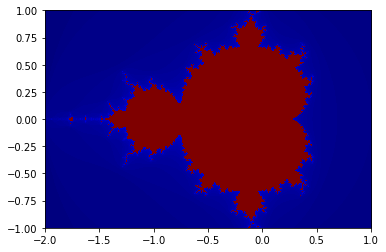

In [6]:
%matplotlib inline

from numba import jit
import numpy as np
from pylab import imshow, jet, show, ion

@jit
def mandel(x, y, max_iters):
    """
    Given the real and imaginary parts of a complex number,
    determine if it is a candidate for membership in the Mandelbrot
    set given a fixed number of iterations.
    """
    i = 0
    c = complex(x,y)
    z = 0.0j
    for i in range(max_iters):
        z = z*z + c
        if (z.real*z.real + z.imag*z.imag) >= 4:
            return i

    return 255

@jit
def create_fractal(min_x, max_x, min_y, max_y, image, iters):
    height = image.shape[0]
    width = image.shape[1]

    pixel_size_x = (max_x - min_x) / width
    pixel_size_y = (max_y - min_y) / height
    for x in range(width):
        real = min_x + x * pixel_size_x
        for y in range(height):
            imag = min_y + y * pixel_size_y
            color = mandel(real, imag, iters)
            image[y, x] = color

    return image

image = np.zeros((2000, 3000), dtype=np.uint8)

with Timer() as t:
    mandelbrot = create_fractal(-2.0, 1.0, -1.0, 1.0, image, 20)
print("Time to create fractal: {0}".format(t.interval))
    
imshow(mandelbrot, extent=[-2, 1, -1, 1])
jet()
ion()
show()


We can do more. The following code parallelizes the execution of the Mandelbrot function.

Time to create fractal: 0.14829707145690918


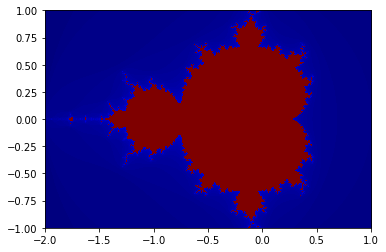

In [7]:
%matplotlib inline

from numba import jit, prange
import numpy as np
from pylab import imshow, jet, show, ion

@jit(nopython=True)
def mandel(x, y, max_iters):
    """
    Given the real and imaginary parts of a complex number,
    determine if it is a candidate for membership in the Mandelbrot
    set given a fixed number of iterations.
    """
    i = 0
    c = complex(x,y)
    z = 0.0j
    for i in range(max_iters):
        z = z*z + c
        if (z.real*z.real + z.imag*z.imag) >= 4:
            return i

    return 255

@jit(['uint8[:,:](float64, float64, float64, float64, uint8[:, :], uint8)'], nopython=True, parallel=True)
def create_fractal(min_x, max_x, min_y, max_y, image, iters):
    height = image.shape[0]
    width = image.shape[1]

    pixel_size_x = (max_x - min_x) / width
    pixel_size_y = (max_y - min_y) / height
    for x in prange(width):
        real = min_x + x * pixel_size_x
        for y in range(height):
            imag = min_y + y * pixel_size_y
            color = mandel(real, imag, iters)
            image[y, x] = color
    return image

image = np.zeros((2000, 3000), dtype=np.uint8)

with Timer() as t:
    mandelbrot = create_fractal(-2.0, 1.0, -1.0, 1.0, image, 20)
print("Time to create fractal: {0}".format(t.interval))

imshow(mandelbrot, extent=[-2, 1, -1, 1])
jet()
ion()
show()

The key to the parallelization is the `prange` command in the for-loop. This is similar to the parallel for-loop that we have seen with OpenMP and tells Numba to spread out the computation to multiple CPU cores. However, it is essential that Numba knows all data types, so that no Python calls will be performed during the parallel loop. This is ensured by the option `nopython=True` and by explicitly specifying the input and output types. 

Numba has many more features, some of which we will get to know throughout the course.

We can easily inspect the code that Numba generates. Consider the following simple function.

In [2]:
def sum(a, b):
    return a + b